# Spooky Author Identification <a class='tocSkip'>

By: [**Courtney Ferguson Lee**](https://www.linkedin.com/in/courtneyfergusonlee/)

<img src='https://raw.githubusercontent.com/spacecadet84/spooky_author_id/master/images/authors.png'>

# Introduction

This notebook tutorial will demonstrate how to use natural language processing to identify authors from text excerpts. The authors include Edgar Allen Poe, HP Lovecraft and Mary Shelley. It will also serve as my initial entry into Kaggle's natural language contest of the same name. The purpose is not to get to the top of the Kaggle leaderboard, but to help beginners develop their understanding of text learning. We'll start by exploring the structure of the data, then clean up any inconsistencies and create a few visualizations before feeding the data into our algorithm.

# Load Modules

There are a lot of libraries below, so it may be prudent to explain the purpose of a few of the major players. Pandas and Numpy will be used to manipulate our CSV files as necessary, while matplotlib and seaborn will be used to create visualizations so that we can better understand our data. The natural language processing modules will be used to reformat and manipulate our text data so that we can feed it into our machine learning models.

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np
pd.set_option('max_colwidth', 200)
from IPython.display import display

# Visualizations
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
import seaborn as sns
sns.set_style('white')
colors = sns.color_palette()
import missingno as msno

# Misc
from time import time

# Natural Language Processing
import re
from google.cloud import language
from textblob import TextBlob as tb
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

# Machine Learning Models
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix

# Load Data

Our data is given to us in the form of two CSV files containing excerpts from each of the above 3 authors. We have a labeled dataset ("train.csv") which we will use to train our classifier and an unlabeled testing dataset aptly named "test.csv".

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)

# Data Structure

Our training data is composed of 19,579 records and 3 variables: id, text and author. According to the contest page, the id column is a unique identifier for each sentence, which doesn't seem very useful right now. Assuming all exerpts were randomly selected, there shouldn't be any clear patterns from each exerpt's ID.

In [3]:
display(train_df.shape)
display(train_df.info())
display(train_df.describe())

(19579, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19579 entries, 0 to 19578
Data columns (total 3 columns):
id        19579 non-null object
text      19579 non-null object
author    19579 non-null object
dtypes: object(3)
memory usage: 459.0+ KB


None

,id,text,author
count,19579,19579,19579
unique,19579,19579,3
top,id07303,"I escaped from them to the room where lay the body of Elizabeth, my love, my wife, so lately living, so dear, so worthy.",EAP
freq,1,1,7900


# Feature Engineering

The unicode characters aren't playing nicely with textblob or nltk. Let's convert them to ascii strings for now. We risk losing information from special characters, but if that becomes an issue we'll come back to this later.

In [4]:
train_df.text = train_df.text.str.decode('utf-8', 'ignore')

## Stem Words

Our next step will be to convert our words into stem words. Stemming is the process of reducing words into their word stem. It may be helpful to go into detail here. For example, let's say we are trying identify whether an excerpt came from an MLA style guide or a baseball article and our classifier encountered the following words:

- formater
- formatted
- formats
- formatting

The above words would all be converted to their stem: format. "So what" you might say. "Why is this even useful?" The main advantage of stemming is that it condenses our featureset, which will help improve the accuracy of our classifier. As we will see further below, text classification involves sparse data, which actually hurts the accuracy of our models (more data is not always more helpful). By stemming our words beforehand, we can reduce the number of features two-fold or three-fold for English words and even more than that in other languages.

In [5]:
def get_stems(words):
    stemmer = SnowballStemmer("english")
    stems = []
    if len(words)>0:
        for word in words:
            stems.append(stemmer.stem(word))
    return " ".join(stems)

In [7]:
stemmer = SnowballStemmer("english")
stemmer.stem('reduced')

u'reduc'

## Lemmas

We will also apply lemmatization to our features. Lemmatization is very similar to stemming in that it involves reducing words, but it does so in a more nuanced way. Whereas stemming applies a coarse algorithm to chop off the ends of words, lemmatization reduces words properly, taking into account part of speech and inflection.

Stemming often results in a non-word whereas lemmatization gets to the morphological base of a word. For example, consider the word 'reduced'. Stemming would convert that word to 'reduc', which is not a word. Lemmatizing the verb 'reduced' would result in its base word 'reduce'.

For our purposes, we will use lemmatization to reduce the number of features in our dataset, but there are other use cases for this technique. Both lemmatization and stemming can be used to improve the accuracy of search algorithms. If a user enters the search terms "code" and "challenges", it would be helpful to include websites that contain the phrase "coding challenge".

In [11]:
def get_lemmas(blob):
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word, pos in blob.tags:
        wordnet_pos = get_wordnet_pos(pos)
        if wordnet_pos:
            lemmas.append(lemmatizer.lemmatize(word, wordnet_pos))
        else: 
            lemmas.append(lemmatizer.lemmatize(word))
    return lemmas

In [12]:
train_df['text_blobs'] = train_df.text.apply(tb)
train_df['text_blob_words'] = train_df.text_blobs.apply(lambda x: (x.words))
train_df['lemmas'] = train_df.text_blobs.apply(get_lemmas)
train_df['lemma_stems'] = train_df.lemmas.apply(get_stems)
train_df['lemmas'] = train_df.lemmas.apply(lambda x: " ".join(x))
train_df['stems'] = train_df.text_blob_words.apply(get_stems)
train_df['words'] = train_df.text_blob_words.apply(lambda x: " ".join(list(x)))
train_df['word_count'] = train_df.text_blob_words.apply(len)

In [18]:
train_df.head()

,id,text,author,text_blobs,text_blob_words,lemmas,lemma_stems,stems,words,word_count,stem_count,lemma_count
0,id26305,"This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so...",EAP,"(T, h, i, s, , p, r, o, c, e, s, s, ,, , h, o, w, e, v, e, r, ,, , a, f, f, o, r, d, e, d, , m, e, , n, o, , m, e, a, n, s, , o, f, , a, s, c, e, r, t, a, i, n, i, n, g, , t, h, e, , d, ...","[This, process, however, afforded, me, no, means, of, ascertaining, the, dimensions, of, my, dungeon, as, I, might, make, its, circuit, and, return, to, the, point, whence, I, set, out, without, b...","[This, process, however, afford, me, no, mean, of, ascertain, the, dimension, of, my, dungeon, a, I, might, make, it, circuit, and, return, to, the, point, whence, I, set, out, without, be, aware,...",this process howev afford me no mean of ascertain the dimens of my dungeon a i might make it circuit and return to the point whenc i set out without be awar of the fact so perfect uniform seem the...,this process howev afford me no mean of ascertain the dimens of my dungeon as i might make it circuit and return to the point whenc i set out without be awar of the fact so perfect uniform seem th...,This process however afforded me no means of ascertaining the dimensions of my dungeon as I might make its circuit and return to the point whence I set out without being aware of the fact so perfe...,41,41,41
1,id17569,It never once occurred to me that the fumbling might be a mere mistake.,HPL,"(I, t, , n, e, v, e, r, , o, n, c, e, , o, c, c, u, r, r, e, d, , t, o, , m, e, , t, h, a, t, , t, h, e, , f, u, m, b, l, i, n, g, , m, i, g, h, t, , b, e, , a, , m, e, r, e, , m, i, ...","[It, never, once, occurred, to, me, that, the, fumbling, might, be, a, mere, mistake]","[It, never, once, occur, to, me, that, the, fumbling, might, be, a, mere, mistake]",it never onc occur to me that the fumbl might be a mere mistak,it never onc occur to me that the fumbl might be a mere mistak,It never once occurred to me that the fumbling might be a mere mistake,14,14,14
2,id11008,"In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfact...",EAP,"(I, n, , h, i, s, , l, e, f, t, , h, a, n, d, , w, a, s, , a, , g, o, l, d, , s, n, u, f, f, , b, o, x, ,, , f, r, o, m, , w, h, i, c, h, ,, , a, s, , h, e, , c, a, p, e, r, e, d, , ...","[In, his, left, hand, was, a, gold, snuff, box, from, which, as, he, capered, down, the, hill, cutting, all, manner, of, fantastic, steps, he, took, snuff, incessantly, with, an, air, of, the, gre...","[In, his, left, hand, be, a, gold, snuff, box, from, which, a, he, caper, down, the, hill, cut, all, manner, of, fantastic, step, he, take, snuff, incessantly, with, an, air, of, the, great, possi...",in his left hand be a gold snuff box from which a he caper down the hill cut all manner of fantast step he take snuff incess with an air of the great possibl self satisfact,in his left hand was a gold snuff box from which as he caper down the hill cut all manner of fantast step he took snuff incess with an air of the greatest possibl self satisfact,In his left hand was a gold snuff box from which as he capered down the hill cutting all manner of fantastic steps he took snuff incessantly with an air of the greatest possible self satisfaction,36,36,36
3,id27763,"How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering...",MWS,"(H, o, w, , l, o, v, e, l, y, , i, s, , s, p, r, i, n, g, , A, s, , w, e, , l, o, o, k, e, d, , f, r, o, m, , W, i, n, d, s, o, r, , T, e, r, r, a, c, e, , o, n, , t, h, e, , s, i, x, ...","[How, lovely, is, spring, As, we, looked, from

# Visualizations

Breaking down the excerpts by author, we can see that the data is slightly unbalanced with Edgar Allen Poe contributing about 25% more texts than Mary Shelley or HP Lovecraft.

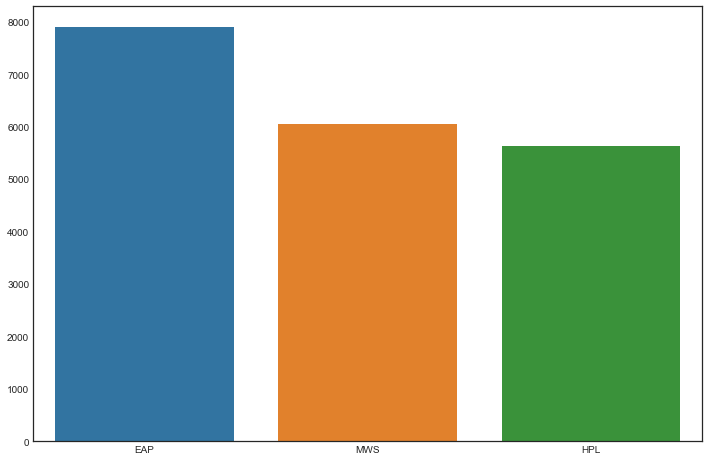

In [14]:
author_counts = train_df.author.value_counts()
sns.barplot(x=author_counts.index, y=author_counts.values)
plt.show()

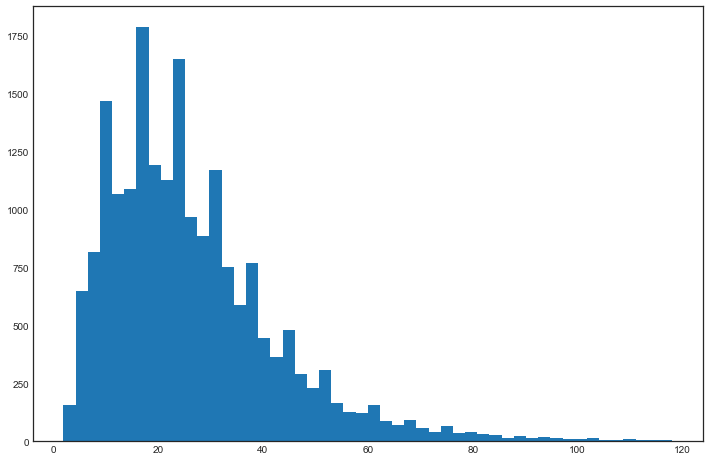

In [15]:
plt.hist(train_df[train_df.word_count<120].word_count, bins=50)
plt.show()

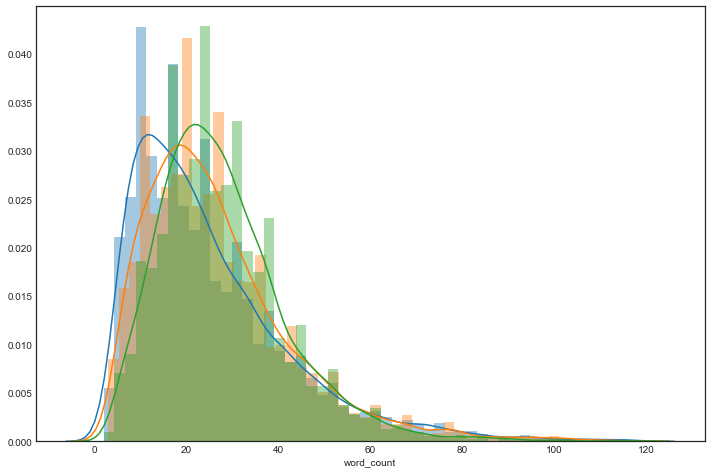

In [16]:
sns.distplot(
    train_df[(train_df.author=='EAP') & (train_df.word_count<120)].word_count,
    color=colors[0]
)
sns.distplot(
    train_df[(train_df.author=='MWS') & (train_df.word_count<120)].word_count,
    color=colors[1]
)
sns.distplot(
    train_df[(train_df.author=='HPL') & (train_df.word_count<120)].word_count,
    color=colors[2]
)
plt.show()

Edgar Allen Poe appears to have the lowest average word count, followed by Mary Shelley, but it's difficult to tell whether it's significant. In the next iteration, that may be a useful feature, but we'll omit it for now.

# Modeling

Now that we have a better understanding of our data structure, we can build our machine learning models. We will vectorize our features before feeding them into our algorithms. Vectorization converts a corpus into a sparse matrix of numbers. Every word in the corpus has a unique location within the vector.

Count vectorization transforms each word into a column and transforms each document into a row. Each cell contains a count of the number of times that column's word occurs. While this method can be useful, we may be more interested in words that are unique to certain documents, as opposed to the most popular words. For this reason, we will be using term frequency document inverse frequency (TF-IDF).

In TF-IDF vectorization, columns still represent words and rows still represent documents, but it goes a step further by measuring how unique a word is across all documents. Each cell in the TF-IDF matrix is a product of how frequently the word occurs in a document by how unique it is in the entire corpus of documents. In this exploration, we will be using TF-IDF for its enhanced discriminating power.

There are a number of hyperparameters that can be tuned in tfidf, which can be found [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). We will focus on bigrams and unigrams. When tokenizing our documents, we can break them down to individual words like "Frankenstein", "raven" or "octopus", or into phrases like "you know", "down by", or "any day now". There are advantages and disadvantages to each approach, but we will not know which will lead to better accuracy until we implement them. It is tempting to just use the widest variety of n-grams our processor can handle, but again, more data is not always more helpful. Generating millions of features can actually hurt our accuracy.

## Unigram Vectorization

We'll start with unigrams and try several of the features we engineered earlier on in the analysis. It's not clear whether words, stems, lemmas or stemmed lemmas will yield the highest accuracy, so we'll try all four in the next coding blocks.

### With Stemming

In [39]:
def vectorize(name, data):
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform(data)
    print "{0} Vector Shape: {1}".format(name, vectors.shape)
    return vectors

In [23]:
def get_scores(vectors, df):
    #x_train, x_test, y_train, y_test = train_test_split(vectors, df.author, test_size=.3, random_state=42)
    
    nb = MultinomialNB(alpha=.1)
    svm = LinearSVC(random_state=42)
    logr = LogisticRegression(random_state=42)
    sgd = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
    rf = RandomForestClassifier(random_state=42)

    classifiers = [
        ("Naive Bayes", nb), 
        ("Support Vector Machines", svm), 
        ("Logistic Regression", logr), 
        ("Stochastic Gradient Dissent", sgd), 
        ("Random Forests", rf)]

    scores = []

    for classifier in classifiers:
        name = classifier[0]
        clf = classifier[1]
        accuracies = cross_val_score(clf, vectors, df.author, cv=3)
        scores.append((name, np.mean(accuracies)))
        #clf.fit(x_train, y_train)
        #pred = clf.predict(x_test)
        #scores.append((name, accuracy_score(pred, y_test)))

    return scores


In [21]:
def plot_scores(scores):
    scores_df = pd.DataFrame(scores, columns=["name", "score"])
    scores_df.score *= 100
    plt.bar(range(len(scores_df.name)), scores_df.score, alpha=.7, color=colors[0])
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.xticks(range(len(scores_df.name)), scores_df.name)
    for x,y in zip(range(len(scores_df.name)), scores_df.score):
        plt.text(x, y, "{0:0.1f}".format(y), ha='center', va='bottom')
    plt.show()

Stem Vector Shape: (19579, 15130)


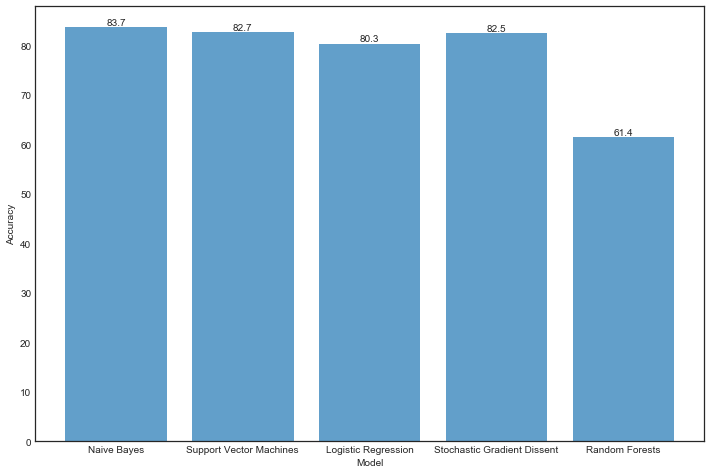

In [40]:
vectors = vectorize("Stem", train_df.stems)
scores = get_scores(vectors, train_df)
plot_scores(scores)

## Lemmatization

Word Vector Shape: (19579, 20205)


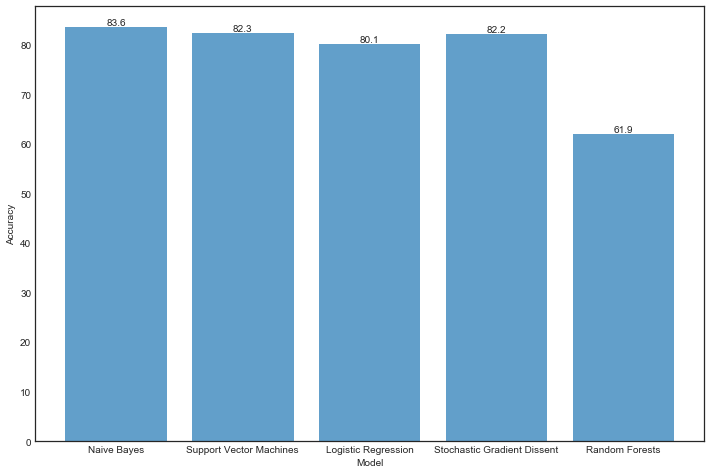

In [45]:
vectors = vectorize("Word", train_df.lemmas)
scores = get_scores(vectors, train_df)
plot_scores(scores)

### Stemming and Lemmatization

Word Vector Shape: (19579, 14912)


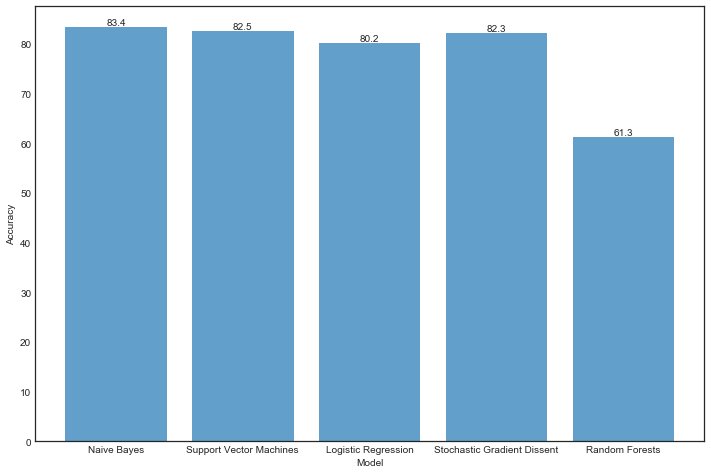

In [30]:
vectors = vectorize("Word", train_df.lemma_stems)
scores = get_scores(vectors, train_df)
plot_scores(scores)

### Without Stemming

Word Vector Shape: (19579, 25053)


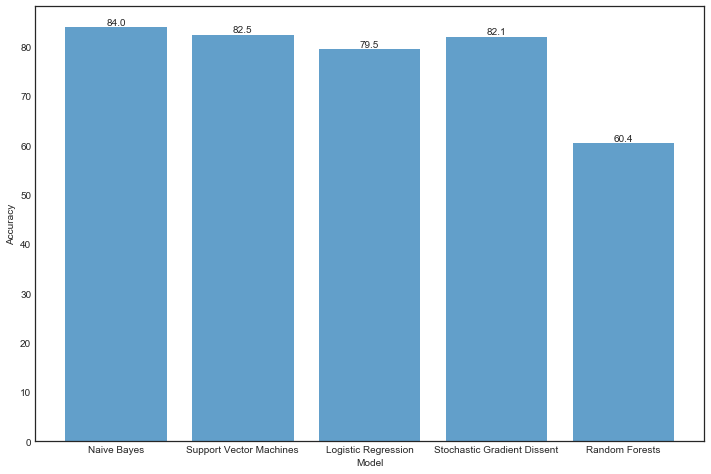

In [31]:
vectors = vectorize("Word", train_df.words)
scores = get_scores(vectors, train_df)
plot_scores(scores)

Raw words led to the highest accuracy by a narrow margin (84% vs 83.7% for stems and 83.6% for lemmas). Because the results were so close, it may be prudent to test all 3 when using bigrams.

## Bigram Vectorization

### With Stemming

In [37]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
vectors = vectorizer.fit_transform(train_df.stems)
vectors.shape

(19579, 218336)

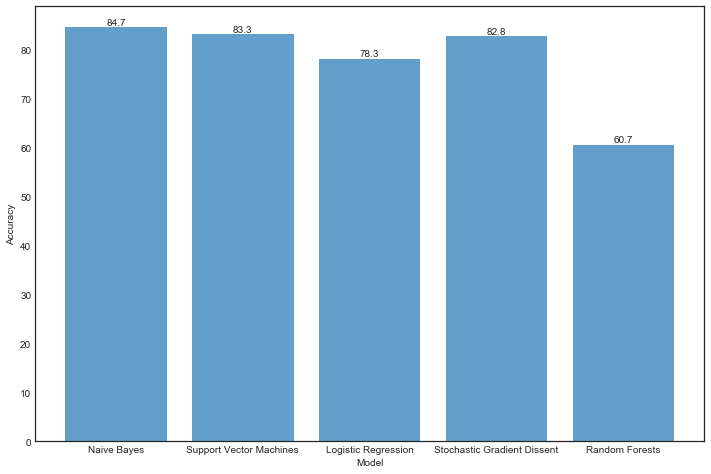

In [38]:
scores = get_scores(vectors, train_df)
plot_scores(scores)

### With Lemmatization

In [46]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
vectors = vectorizer.fit_transform(train_df.lemmas)
vectors.shape

(19579, 222658)

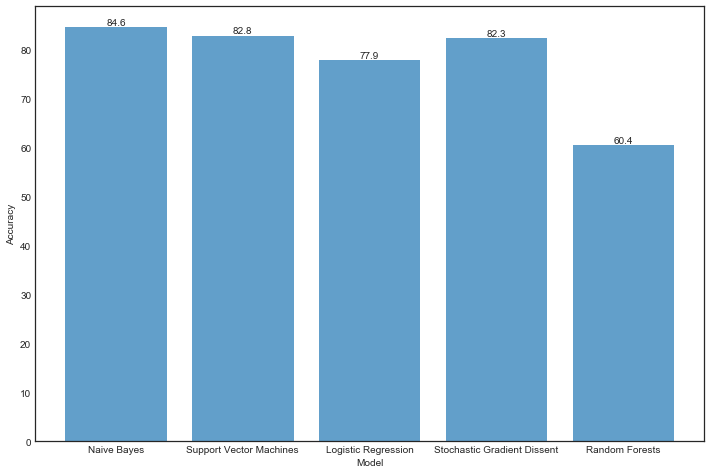

In [47]:
scores = get_scores(vectors, train_df)
plot_scores(scores)

### Without Stemming

In [41]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
vectors = vectorizer.fit_transform(train_df.words)
vectors.shape

(19579, 248827)

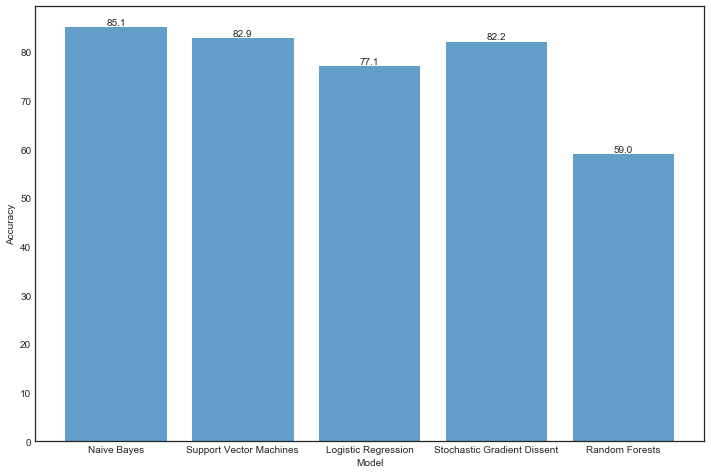

In [57]:
scores = get_scores(vectors, train_df)
plot_scores(scores)

Again, our stemless words came out on top with 85.1% accuracy this time. Not bad for the humbly named Naive Bayes approach.

# Conclusions

Overall, this was a great first step. The 85.1% accuracy is not as high as I had hoped but it is a great baseline from which to improve. In the next iteration, I will use GridSearchCV to optimize our parameters and spend more on feature engineering. Thanks for taking the time to read this.